In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
data_dir2 = data_base_dir + 'Movielens Latest/ml-latest/'
data_dir = data_base_dir + 'serendipity-sac2018/'

output_dir = data_dir + 'output4/'

answers = data_dir + 'answers.csv'
recommendations = data_dir + 'recommendations.csv'

# genome_scores = data_dir + 'tag_genome.csv'
# genome_scores = data_dir + 'ml20mgenome-scores.csv'
genome_scores = data_dir + 'mlLatestgenome-scores.csv'

genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
training = data_dir + 'training.csv'
tags = data_dir + 'tags.csv'

movies_df = pd.read_csv(movies)

answers_df = pd.read_csv(answers)
ratings_df = pd.read_csv(training)

# read all users and filter ratings df
recommendations_df = pd.read_csv(recommendations)
recommendations_df

all_user_ids = recommendations_df['userId'].unique().tolist()

count_df = answers_df.groupby('userId').count()
count_df[count_df['movieId'] == 5]
all_user_ids.extend(count_df[count_df['movieId'] == 5].index.values.tolist())
all_user_ids = np.unique(np.array(all_user_ids))

all_movie_ids = ratings_df['movieId'].unique()

cut_recommendations = recommendations_df[recommendations_df['movieId'].isin(all_movie_ids)]
count_df = cut_recommendations.groupby('userId').count()
# count_df.describe()
all_user_ids = count_df[count_df['movieId'] == 8].index.values

# TODO uncomment code to exclude excluded_users 
#----------------------------------------------

#----------------------------------------------

genome_scores_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')

tag_genome_movies = genome_scores_df.index.values
tag_genome_movies.size

# filter ratings for movies watched only by these users
ratings_df = ratings_df[ratings_df['userId'].isin(all_user_ids)]

# filter ratings for movies only having tag-genome scores
ratings_df = ratings_df[ratings_df['movieId'].isin(tag_genome_movies)]

count_df = ratings_df.groupby('userId').count()

# choose users who have watched 2 or more movies
all_user_ids = count_df[count_df['movieId'] >= 2].index.values

class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine', weighted=True):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df
        self.weighted = weighted

        # preprocessing and other calculations
        term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = pd.DataFrame(
            pairwise_distances(term_vector_df, metric='cosine'),
            index=term_vector_df.index,
            columns=term_vector_df.index)

    def get_predicted_rating(self, user_id, candidate_movie_id, user_movies, K):
        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values

        predicted = self.predict_rating(user_id, candidate_movie_id, users_all_ratings_df, K)

        return predicted

    def predict_rating(self, user_id, candidate_movie_id,
                       users_all_ratings_df,
                       K):
        user_ratings = users_all_ratings_df['rating'].values[:K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:K]

        predicted_rating = 0
        if self.weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        return predicted_rating


class SerendipityCalculator:

    def __init__(this, ratings_df, movie_terms_df, user_genome_terms_df, primitive_recommender,
                 round_decimals,
                 unexpected_ratio, K=8):
        this.ratings_df = ratings_df
        this.movie_terms_df = movie_terms_df
        this.user_genome_terms_df = user_genome_terms_df
        this.primitive_recommender = primitive_recommender
        this.round_decimals = round_decimals
        this.unexpected_ratio = unexpected_ratio
        this.RL_SIZE = K

    def calculate_unexpectedness(this, user_id, recommendation_list, round_decimals=6,
                                 users_movies=None,
                                 unexpected_ratio=0.001):
        # get term vec for all movies watched by the user
        if users_movies is None:
            users_movies = this.ratings_df[this.ratings_df['userId'] == user_id]['movieId'].values

        user_term_vec = this.movie_terms_df.loc[users_movies, :].fillna(0).values

        # load genome tags for recommended movies
        recommendations_term_vec = this.movie_terms_df.loc[recommendation_list, :].fillna(0).values

        # calculate distances of all recommended movies with all movies watched by user
        distance_from_user_profile = pd.DataFrame(
            pairwise_distances(user_term_vec, recommendations_term_vec, metric='cosine'))

        # get minimum distance from users profile for each recommended movie
        min_distances = distance_from_user_profile.min().values

        # round distances to N decimals - parameter round_decimals
        unexpectedness = np.around(min_distances, decimals=round_decimals)

        unexpected_movies = recommendation_list[unexpectedness >= unexpected_ratio]

        return unexpected_movies

    def calculate_usefulness(this, user_id, recommendation_list, primitive_recommender=None,
                             like_threshold=3,
                             K=50):
        if primitive_recommender is None:
            primitive_recommender = this.primitive_recommender

        users_movies = this.ratings_df[this.ratings_df['userId'] == user_id]['movieId'].values

        predicted_ratings_list = list()

        # get predicted rating for each movie using the primitive recommender
        for candidate_movie_id in recommendation_list:
            predicted_rating = primitive_recommender.get_predicted_rating(user_id,
                                                                          candidate_movie_id,
                                                                          users_movies, K=K)
            predicted_ratings_list.append(predicted_rating)

        predicted_ratings_list = np.array(predicted_ratings_list)

        # filter as useful if potential rating is above or equal to the like threshold
        useful_movies = recommendation_list[predicted_ratings_list >= like_threshold]

        return useful_movies

    def calculate_serendipity(this, user_id, recommendation_list):
        unexpected_movies = this.calculate_unexpectedness(user_id, recommendation_list)
        useful_movies = this.calculate_usefulness(user_id, recommendation_list)

        serendipity = len(np.intersect1d(unexpected_movies, useful_movies)) / \
                      len(recommendation_list)

        return serendipity

    def calculate_diversity(this, user_id, recommendation_list):
        # movie_genomes_df = movie_genome_scores_df.loc[recommendation_list, :]
        movie_genomes_df = this.movie_terms_df.loc[recommendation_list, :]
        user_vector_df = this.user_genome_terms_df.loc[user_id, :].values.reshape(1, -1)
        # user_vector_df = this.

        model_pairwise_scores_df = pd.DataFrame(index=recommendation_list)
        movie_genomes_df.fillna(0, inplace=True)
        user_vector_df.fillna(0, inplace=True)
        model_pairwise_scores_df['similarity'] = pairwise_distances(user_vector_df,
                                                                    movie_genomes_df.values,
                                                                    metric='cosine').reshape(-1, 1)
        model_pairwise_scores_df['diversity'] = 1 - model_pairwise_scores_df['similarity']

        all_movies = model_pairwise_scores_df.index.values
        movie_genomes_df = this.movie_terms_df.loc[all_movies, :]

        # calculating diversity of a list (1-SIM_ij)
        intra_list_distances_df = pd.DataFrame(
            1 - pairwise_distances(movie_genomes_df.values, movie_genomes_df.values,
                                   metric='cosine'), index=all_movies,
            columns=all_movies)
        diversity_of_list = intra_list_distances_df.sum(axis=1).sum() * (
                1 / (this.RL_SIZE * (this.RL_SIZE - 1)))
        similarity_of_list = 1 - diversity_of_list

        # this is the similarity to user profile
        average_user_similarity = model_pairwise_scores_df['similarity'].mean()

        # diversity from the user profile
        average_user_diversity = model_pairwise_scores_df['diversity'].mean()

        return diversity_of_list, similarity_of_list, average_user_similarity, average_user_diversity

In [8]:
all_movie_ids = ratings_df['movieId'].unique()

cut_recommendations = recommendations_df[recommendations_df['movieId'].isin(all_movie_ids)]
count_df = cut_recommendations.groupby('userId').count()
# count_df.describe()
count_df[count_df['movieId'] == 8].index.values

array([100200, 100521, 100972, 100998, 101049, 101170, 101263, 101318,
       101721, 101743, 101799, 101818, 101889, 102206, 102226, 102355,
       102665, 103266, 103561, 103573, 103636, 104273, 105111, 105148,
       105520, 106038, 106850, 106872, 106993, 107522, 107695, 107868,
       108013, 108188, 108211, 108271, 108419, 108516, 108657, 108838,
       108987, 109086, 109135, 109289, 109335, 109384, 109441, 109655,
       109763, 110038, 110039, 110077, 110246, 110296, 110343, 110386,
       110525, 110601, 110988, 111399, 111527, 111714, 111737, 111751,
       111869, 112139, 112394, 112406, 112600, 112947, 112971, 113031,
       113138, 113394, 113591, 113673, 113679, 113769, 113922, 114412,
       114454, 114756, 114855, 114934, 114952, 115003, 115169, 115551,
       115930, 116072, 116123, 116352, 116453, 116680, 117071, 117112,
       117154, 117439, 117986, 118007, 118032, 118062, 118144, 118322,
       118350, 118409, 118415, 118509, 118524, 118726, 118774, 118829,
      

In [9]:
recommendations_dir = '../../generated_data/final_recommendations/'

baseline = recommendations_dir + 'Baseline Recommendations/'

# CB_recommendations_dir =  recommendations_dir + 'CB_Recommendations_Rcu05_Su10_div80_ci05/'
# thresholded_dir = CB_recommendations_dir + 'thresholded'

K_Neighbours = 8
model = 'main_model_'
# main_model_header = 'main_model_full_'
# main_model_lemm_header = 'main_model_lemmatized_'

label = '_simMov_serendipity2018_relevantThreshold_'
finish_label = '_K' + str(K_Neighbours) + '.csv'

# relevant_movies_thresholds = [0, 0.2, 0.4, 0.6, 0.8, 1]
relevant_movies_thresholds = [0, 0.2]
# relevant_movies_thresholds = [0, 0.2]

cb_recommendations_file_names = list()

types_under_test = ['full', 'lemmatized']

models = list()

# for non-thresholded main models
for vec_type in types_under_test:
    for relevant_m_th in relevant_movies_thresholds:
        file_name = model + vec_type + label + str(relevant_m_th) + finish_label
        cb_recommendations_file_names.append(file_name)
        model_name = 'main_' + vec_type + '_relv_' + str(relevant_m_th)
        models.append(model_name)
        
threshold_headers = ['full_thresholded_', 'lemmatized_thresholded_']
thresholds = [0.4]

# for thresholded main models
for vec_type in threshold_headers:
    for threshold in thresholds:
        for relevant_m_th in relevant_movies_thresholds:
            file_name = vec_type + str(threshold) + label + str(relevant_m_th) + finish_label
            cb_recommendations_file_names.append(file_name)
            model_name = vec_type + '_relv_' + str(relevant_m_th)
            models.append(model_name)

        
# models = ['main_full_mov0', 'main_full_mov0.2', 'main_full_mov0.4', 'main_full_mov0.6', 'main_full_mov1']

print('models', models)
cb_recommendations_file_names

models ['main_full_relv_0', 'main_full_relv_0.2', 'main_lemmatized_relv_0', 'main_lemmatized_relv_0.2', 'full_thresholded__relv_0', 'full_thresholded__relv_0.2', 'lemmatized_thresholded__relv_0', 'lemmatized_thresholded__relv_0.2']


['main_model_full_simMov_serendipity2018_relevantThreshold_0_K8.csv',
 'main_model_full_simMov_serendipity2018_relevantThreshold_0.2_K8.csv',
 'main_model_lemmatized_simMov_serendipity2018_relevantThreshold_0_K8.csv',
 'main_model_lemmatized_simMov_serendipity2018_relevantThreshold_0.2_K8.csv',
 'full_thresholded_0.4_simMov_serendipity2018_relevantThreshold_0_K8.csv',
 'full_thresholded_0.4_simMov_serendipity2018_relevantThreshold_0.2_K8.csv',
 'lemmatized_thresholded_0.4_simMov_serendipity2018_relevantThreshold_0_K8.csv',
 'lemmatized_thresholded_0.4_simMov_serendipity2018_relevantThreshold_0.2_K8.csv']

Directory:  recommendations_algo3_all25/
Progress: 100.000000 %total time taken 218.143890 seconds


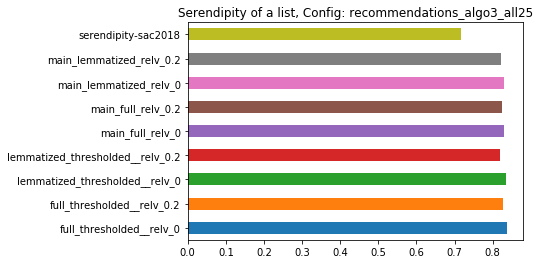

Directory:  recommendations_algo3_rcu05_su10_div80_ci05/
Progress: 100.000000 %total time taken 596.217651 seconds


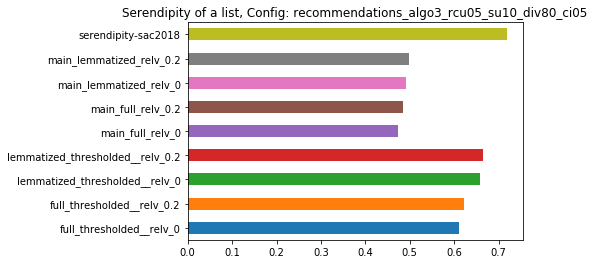

Directory:  recommendations_algo3_rcu10_su30_div50_ci10/
Progress: 100.000000 %total time taken 591.370102 seconds


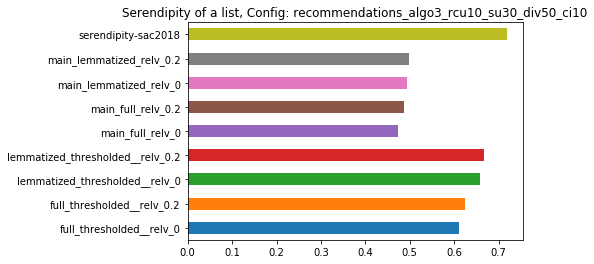

Directory:  recommendations_algo3_rcu40_su20_div15_ci15/
Progress: 100.000000 %total time taken 206.762950 seconds


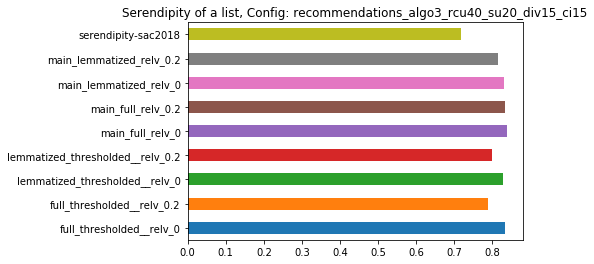

In [26]:
from sklearn.metrics import pairwise_distances
from sys import stdout
unexpected_threshold = 0.1

def update_progress(user_id, user_ids):
    progress = (np.where(user_ids == user_id)[0][0] + 1) / (len(user_ids))
    stdout.write('\rProgress: %f %%' % (progress * 100))
    stdout.flush()

# this, ratings_df, movie_terms_df, user_genome_terms_df, primitive_recommender,
#                  round_decimals,
#                  unexpected_ratio, K=8

# choose and initialize primitive recommender
primitive_recommender = ContentBased_Recommender(term_vector_df=genome_scores_df,
                                                ratings_df=ratings_df, K=50, metric='cosine',
                                                weighted=True)

# serendipity_calculators_list = list()

# this, ratings_df, movie_terms_df, user_genome_terms_df, primitive_recommender,
#                  round_decimals,
#                  unexpected_ratio, K=8
serendipity_calculator = SerendipityCalculator(ratings_df, movie_terms_df=genome_scores_df,
                                               user_genome_terms_df=None,
                          primitive_recommender=primitive_recommender, round_decimals=6,
                          unexpected_ratio=unexpected_threshold)

# load all recommendations

CB_recommendations_dir_list = ['recommendations_algo3_all25/', 'recommendations_algo3_rcu05_su10_div80_ci05/',
                              'recommendations_algo3_rcu10_su30_div50_ci10/', 'recommendations_algo3_rcu40_su20_div15_ci15/']

serendipity_calculations_df_dict = dict()

for CB_rec_dir in CB_recommendations_dir_list[:]:
    cb_recommendations_dfs = list()
    print('Directory: ', CB_rec_dir)
    
    for recommendation_file in cb_recommendations_file_names:
        cb_recommendations_dfs.append(\
            pd.read_csv(recommendations_dir + CB_rec_dir + recommendation_file, index_col=0)\
        )
        
    from time import time

    serendipity_calculations_df = pd.DataFrame()

#     exclude_users = [101579, 100269, 117112, 118774, 143001, 143310, 143385, 144406]

    # TODO add appropriate condition to exclude these users
    #  as these are all potential users who have watched movies less than or equal to 3
    exclude_users = np.array([100269, 101579, 105370, 105938, 106518, 106883, 113401, 116502, 116669, 117112, 119149, 124726, 125102,
                    125112, 125121, 126536, 126770, 127480, 127858, 127965, 128228, 140928, 143001, 143310, 143359, 143385,
                    143945, 145032, 145260, 146811, 147262, 149570, 160486, 171987, 181447, 196901, 197102, 198287,
                    200312, 201550, 206188, 206656, 206697, 206703, 206808])
    
    test_users = np.setdiff1d(all_user_ids, exclude_users)

    start_time = time()
    for user_id in test_users[:]:
        update_progress(user_id, test_users)
        series = pd.Series()
        series.name = user_id

        # serendipity for ser-2018 dataset
        recommendation_list = recommendations_df[recommendations_df['userId'] == user_id]['movieId'].values

        serendipity = serendipity_calculator.calculate_serendipity(user_id, recommendation_list)
        series['serendipity-sac2018'] = serendipity

        # serendipity for all main models
        for i, model in enumerate(models):
            rec_df = cb_recommendations_dfs[i]
            recommendation_list = rec_df.loc[user_id].values

            serendipity = serendipity_calculator.calculate_serendipity(user_id, recommendation_list)
            series[model] = serendipity

        # serendipity for all thresholded main models

        # serendipity for all baseline models (optional)

        serendipity_calculations_df = serendipity_calculations_df.append(series)

    finish_time = time() - start_time

    print('total time taken %f seconds' % finish_time)

    serendipity_calculations_df.mean().plot(title='Serendipity of a list, Config: ' + CB_rec_dir[:-1], kind='barh')
    plt.show()
    serendipity_calculations_df_dict[CB_rec_dir[:-1]]  = serendipity_calculations_df

In [ ]:
# serendipity_calculations_df_dict

In [81]:
serendipity_calculations_df_dict.keys()

dict_keys(['recommendations_algo3_all25', 'recommendations_algo3_rcu05_su10_div80_ci05', 'recommendations_algo3_rcu10_su30_div50_ci10'])

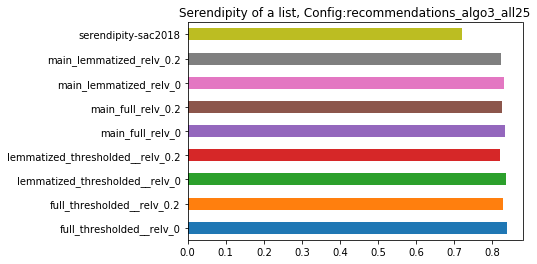

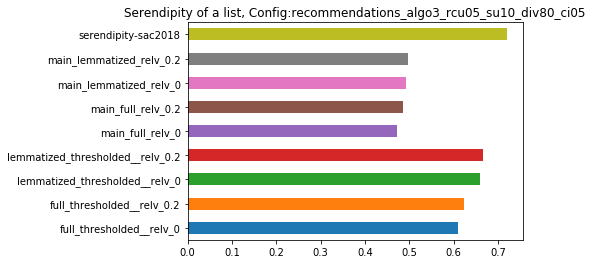

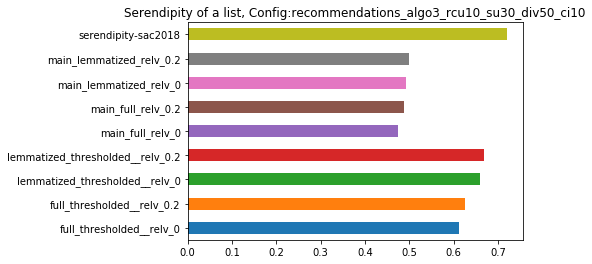

In [84]:
for i, serendipity_calculations_df in enumerate(serendipity_calculations_df_dict.values()):
    serendipity_calculations_df.mean().plot(title='Serendipity of a list, Config:' + list(serendipity_calculations_df_dict.keys())[i] , kind='barh')
    plt.show()

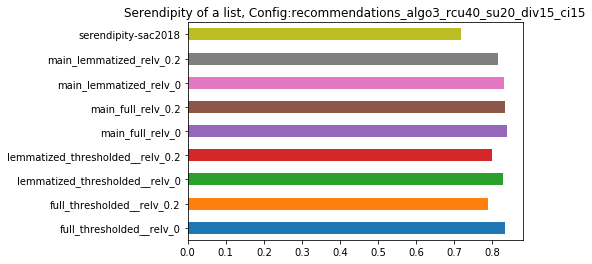

In [15]:
for i, serendipity_calculations_df in enumerate(serendipity_calculations_df_dict.values()):
    serendipity_calculations_df.mean().plot(title='Serendipity of a list, Config:' + list(serendipity_calculations_df_dict.keys())[i] , kind='barh')
    plt.show()

In [28]:
for key in list(serendipity_calculations_df_dict.keys()):
    print('\n\n---------------------------------')
    print(key)
    print('---------------------------------')
    
    df = serendipity_calculations_df_dict[key]
    print(df.describe())



---------------------------------
recommendations_algo3_all25
---------------------------------
       full_thresholded__relv_0  full_thresholded__relv_0.2  \
count                435.000000                  435.000000   
mean                   0.836494                    0.827874   
std                    0.349803                    0.348227   
min                    0.000000                    0.000000   
25%                    1.000000                    0.875000   
50%                    1.000000                    1.000000   
75%                    1.000000                    1.000000   
max                    1.000000                    1.000000   

       lemmatized_thresholded__relv_0  lemmatized_thresholded__relv_0.2  \
count                      435.000000                        435.000000   
mean                         0.833908                          0.819540   
std                          0.356998                          0.354437   
min                          0.000